In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("dazzle-nu/CIS435-CreditCardFraudDetection")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Accessing the training split
train_dataset = ds['train']

# Convert to pandas DataFrame
df = pd.DataFrame(train_dataset)

   Unnamed: 0 trans_date_trans_time        cc_num  \
0           0           1/1/19 0:00  2.703190e+15   
1           1           1/1/19 0:00  6.304230e+11   
2           2           1/1/19 0:00  3.885950e+13   
3           3           1/1/19 0:01  3.534090e+15   
4           4           1/1/19 0:03  3.755340e+14   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ... city_pop  \
0    Banks      F                561 Perry Cove  ...     3495   
1     Gill      F  43039 Riley Greens Suite 393  ...      149   
2  Sanchez      M      594 White Da

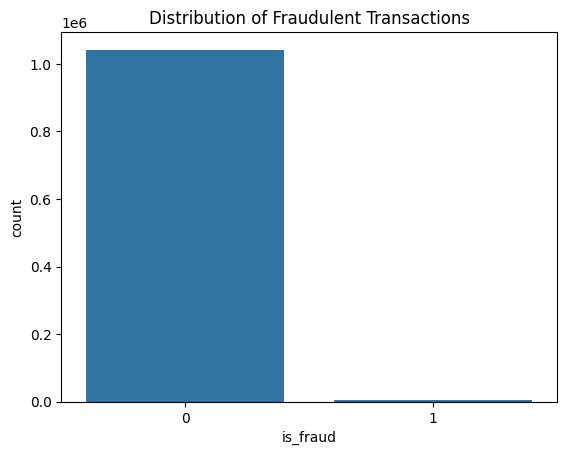

In [ ]:
# Displaying the first few rows of the dataset
print(df.head())

# Checking for missing values
print(df.isnull().sum())

# Checking the distribution of the target variable
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent Transactions')
plt.show()

There are 1,048,575 transactions in total. 99.4% are not fraud transactions 0.6% are farud transactions!

In [ ]:
# Dropping unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

# Verification
print(df.columns)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'Unnamed: 23', '6006'],
      dtype='object')


In [ ]:
df = df.drop(columns=['Unnamed: 23', '6006'])

Removed: Unnamed: 0, Unnamed: 23, 6006 - unnecessary columns in the dataset

unnamed 0 was serial number and unnamed 23, 6006 were empty columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# date format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%m/%d/%y %H:%M')

label_encoder = LabelEncoder()

# Converting categorical columns to numeric data using label encoder
df['merchant'] = label_encoder.fit_transform(df['merchant'])
df['category'] = label_encoder.fit_transform(df['category'])
df['city'] = label_encoder.fit_transform(df['city'])
df['job'] = label_encoder.fit_transform(df['job'])

# Extract hour from transaction time
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour

# Dropping unnecessary columns
df = df.drop(columns=['first', 'last', 'street', 'trans_num'])

print(df.columns)


Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'transaction_hour'],
      dtype='object')


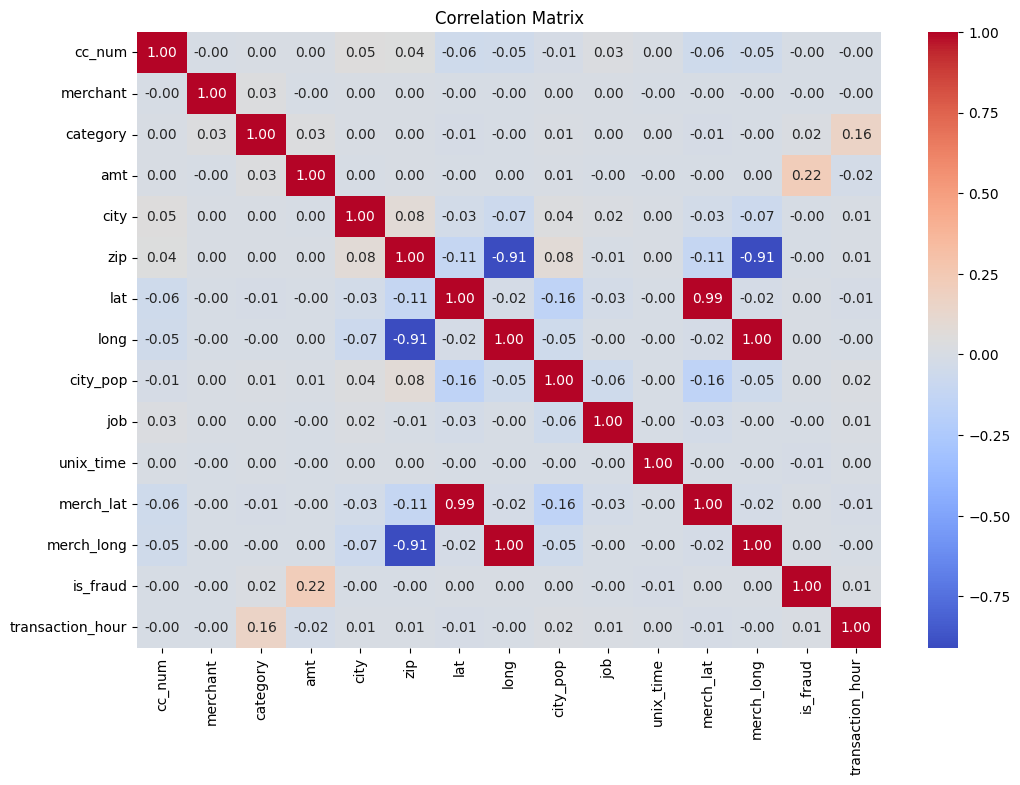

In [ ]:
# Ensure all columns are numeric
numeric_df = df.select_dtypes(include=[int, float])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

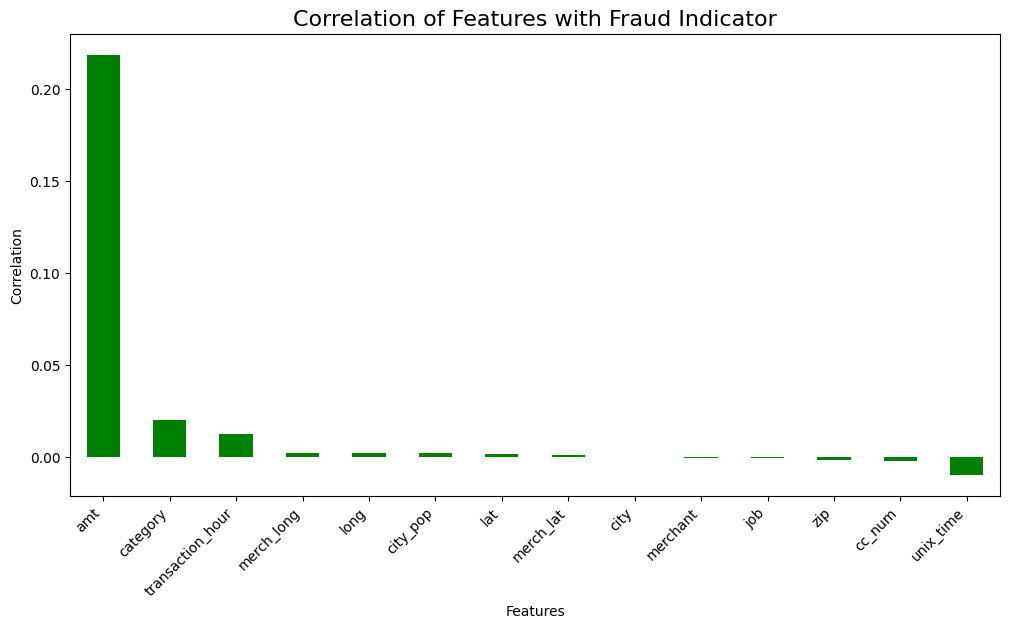

In [ ]:
# Sort correlations with 'is_fraud' and exclude 'is_fraud' itself
sorted_corr = correlation_matrix['is_fraud'].drop('is_fraud').sort_values(ascending=False)

# Plot the sorted correlations
plt.figure(figsize=(12, 6))
sorted_corr.plot(kind='bar', color='green')
plt.title('Correlation of Features with Fraud Indicator', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

amt - most influential feature, with a noticeable positive correlation

category and transaction_hour - show smaller positive correlations, while most other features have negligible correlations

unix_time - negative correlation suggests a potential time-based pattern in fraud detection

In [ ]:
# Removing features with the least correlation to is_fraud
features_to_remove = ['city', 'merch_long', 'merch_lat', 'merchant']

df_reduced = df.drop(columns=features_to_remove)

# Updated Data
print(df_reduced.head())

  trans_date_trans_time        cc_num  category     amt gender state    zip  \
0   2019-01-01 00:00:00  2.703190e+15         8    4.97      F    NC  28654   
1   2019-01-01 00:00:00  6.304230e+11         4  107.23      F    WA  99160   
2   2019-01-01 00:00:00  3.885950e+13         0  220.11      M    ID  83252   
3   2019-01-01 00:01:00  3.534090e+15         2   45.00      M    MT  59632   
4   2019-01-01 00:03:00  3.755340e+14         9   41.96      M    VA  24433   

       lat      long  city_pop  job      dob   unix_time  is_fraud  \
0  36.0788  -81.1781      3495  370   3/9/88  1325376018         0   
1  48.8878 -118.2105       149  428  6/21/78  1325376044         0   
2  42.1808 -112.2620      4154  307  1/19/62  1325376051         0   
3  46.2306 -112.1138      1939  328  1/12/67  1325376076         0   
4  38.4207  -79.4629        99  116  3/28/86  1325376186         0   

   transaction_hour  
0                 0  
1                 0  
2                 0  
3               

In [ ]:
# Converting 'trans_date_trans_time' to datetime
df_reduced['trans_date_trans_time'] = pd.to_datetime(df_reduced['trans_date_trans_time'])

# Extract useful features from the timestamp
df_reduced['year'] = df_reduced['trans_date_trans_time'].dt.year
df_reduced['month'] = df_reduced['trans_date_trans_time'].dt.month
df_reduced['day'] = df_reduced['trans_date_trans_time'].dt.day
df_reduced['hour'] = df_reduced['trans_date_trans_time'].dt.hour

# Drop the original timestamp column
df_reduced = df_reduced.drop(columns=['trans_date_trans_time'])

# Converting categorical variables to numeric
df_reduced = pd.get_dummies(df_reduced, columns=['category', 'gender', 'state'], drop_first=True)


In [ ]:
# Convert 'dob' to datetime
df_reduced['dob'] = pd.to_datetime(df_reduced['dob'], errors='coerce')

# Calculate age from 'dob'
df_reduced['age'] = (pd.to_datetime('today') - df_reduced['dob']).dt.days // 365

# Drop the original 'dob' column
df_reduced = df_reduced.drop(columns=['dob'])

<ipython-input-13-97334a991624>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_reduced['dob'] = pd.to_datetime(df_reduced['dob'], errors='coerce')


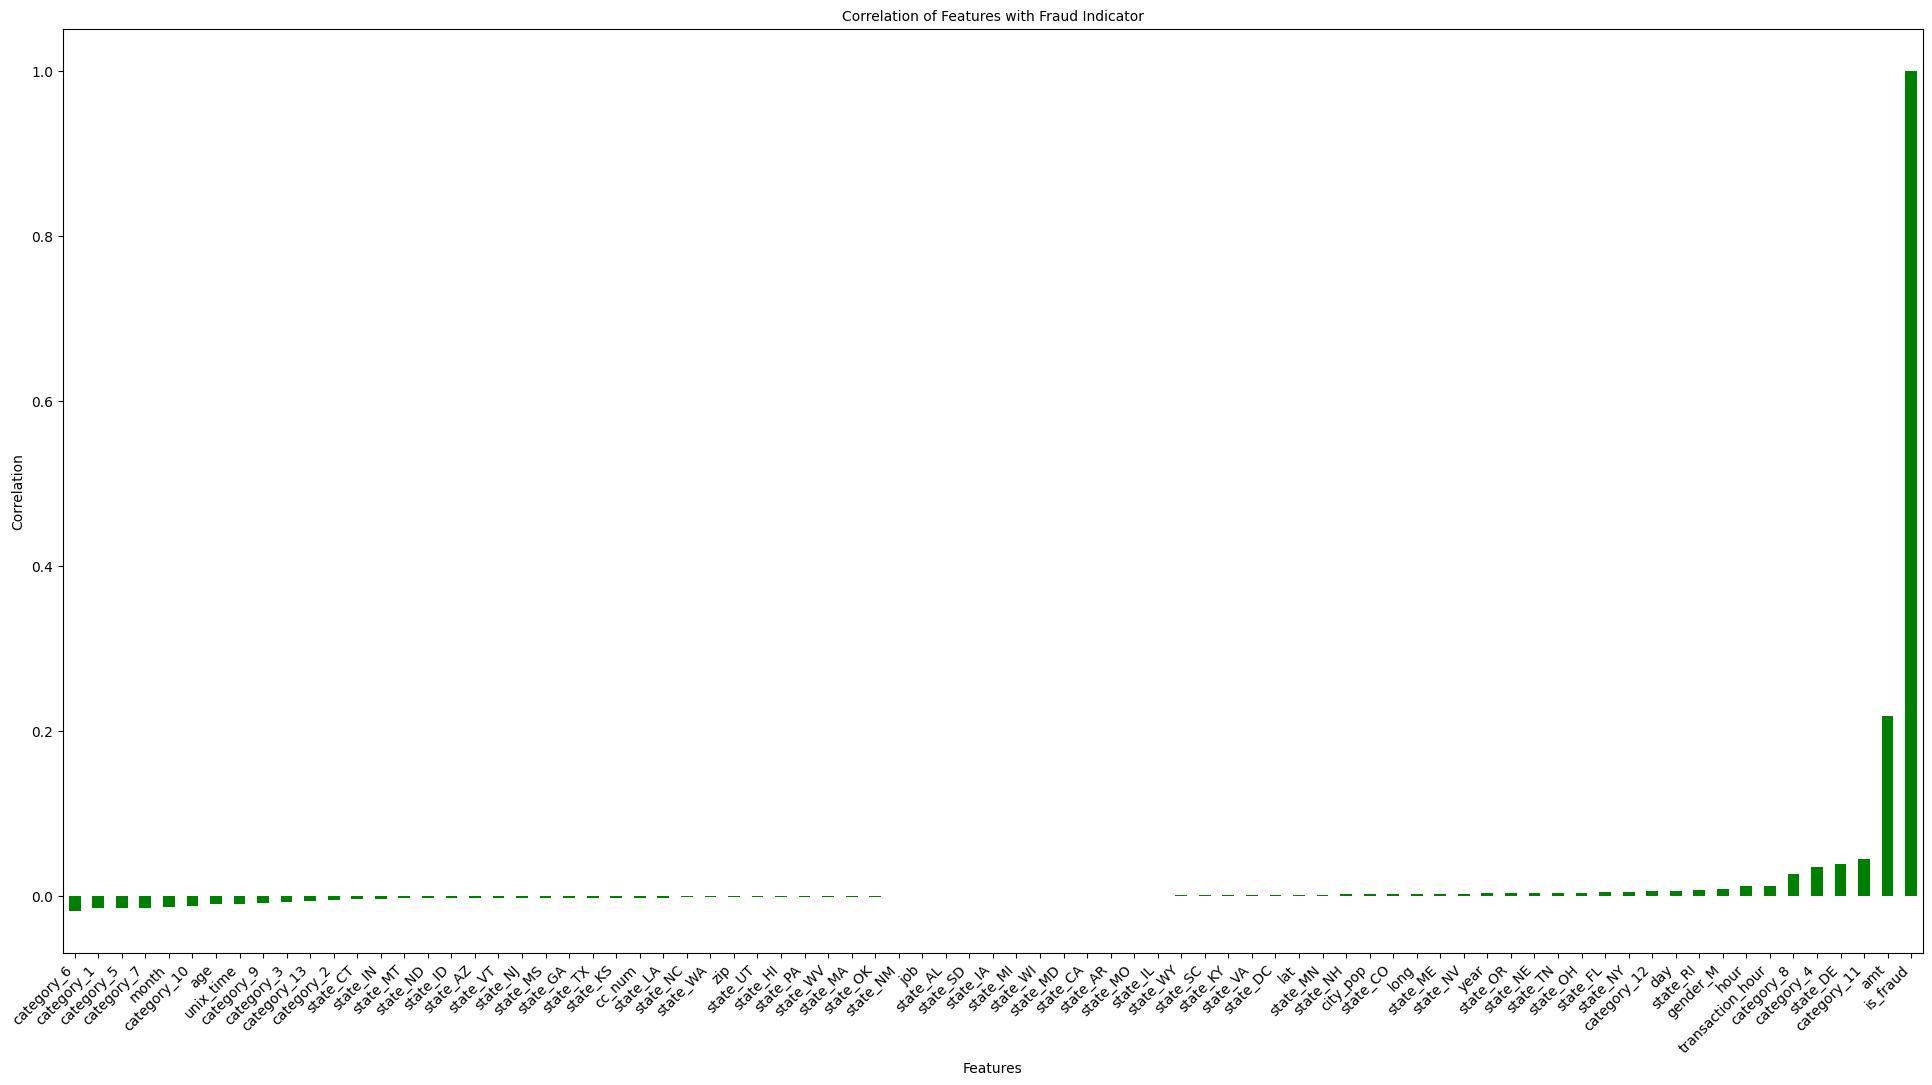

In [ ]:
correlation_matrix = df_reduced.corr()
is_fraud_corr = correlation_matrix['is_fraud']
sorted_corr = is_fraud_corr.sort_values()

# Plot the sorted correlations
plt.figure(figsize=(24, 12))
sorted_corr.plot(kind='bar', color='green')
plt.title('Correlation of Features with Fraud Indicator', fontsize=10)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Defining target variable
X = df_reduced.drop(columns=['is_fraud'])
y = df_reduced['is_fraud']

In [ ]:
print(X.shape)  # Check the shape of feature set
print(y.value_counts())  # Check class distribution in the target variable


(1048575, 78)
is_fraud
0    1042569
1       6006
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


**LOGISTIC REGRESSION**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

we used class weights here because by assigning a higher weight to the minority class and a lower weight to the majority class, the model will penalize misclassifications of the minority class more heavily.
It increases the model's sensitivity (recall) for the minority class while balancing overall performance.

ROC-AUC: 0.5077418072040434
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    208514
           1       0.00      0.00      0.00      1201

    accuracy                           0.99    209715
   macro avg       0.50      0.50      0.50    209715
weighted avg       0.99      0.99      0.99    209715



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


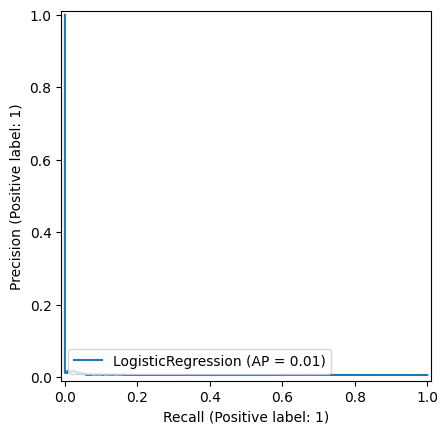

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, PrecisionRecallDisplay

# Make predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")
print(classification_report(y_val, y_pred))

# Plot the Precision-Recall curve
PrecisionRecallDisplay.from_estimator(model, X_val, y_val)

The Average Precision (AP) is quite low, likely due to the severe class imbalance in the dataset. This indicates the Logistic Regression model is struggling to effectively detect fraudulent transactions without fine-tuning

In [ ]:
print(y_train.value_counts())

is_fraud
0    834055
1      4805
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.5077418072040434


In [ ]:
threshold = 0.1  # Example: Lowering the threshold to 0.1
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate with adjusted threshold
print(classification_report(y_val, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    208514
           1       0.01      1.00      0.01      1201

    accuracy                           0.01    209715
   macro avg       0.00      0.50      0.01    209715
weighted avg       0.00      0.01      0.00    209715



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']  # Regularization type
}

# Grid search
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=3
)
grid_search.fit(X_train, y_train)

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Best Parameters: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# Predict with the best model
y_pred_proba_tuned = best_model.predict_proba(X_val)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_val, y_pred_proba_tuned)
print(f"ROC-AUC (Tuned): {roc_auc}")

# Classification Report
y_pred_tuned = (y_pred_proba_tuned >= 0.5).astype(int)
print(classification_report(y_val, y_pred_tuned))

ROC-AUC (Tuned): 0.5077418072040434
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    208514
           1       0.00      0.00      0.00      1201

    accuracy                           0.99    209715
   macro avg       0.50      0.50      0.50    209715
weighted avg       0.99      0.99      0.99    209715



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model is barely better than random guessing, indicating it cannot distinguish between the two classes (fraud vs. legitimate).

**RANDOM FOREST**

ROC-AUC (Random Forest): 0.9829730951240817
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    208514
           1       0.14      0.91      0.24      1201

    accuracy                           0.97    209715
   macro avg       0.57      0.94      0.61    209715
weighted avg       0.99      0.97      0.98    209715



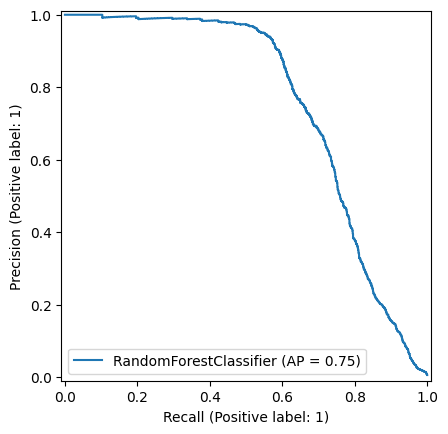

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, PrecisionRecallDisplay

# Initialize Random Forest with class weighting
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate metrics
roc_auc_rf = roc_auc_score(y_val, y_pred_proba_rf)
print(f"ROC-AUC (Random Forest): {roc_auc_rf}")

# Classification Report
y_pred_rf = rf_model.predict(X_val)
print(classification_report(y_val, y_pred_rf))

# Plot Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(rf_model, X_val, y_val)

marked improvement over Logistic Regression's performance, RF - it is capable of increasing recall, but this sacrifices precision.

Precision gradually decreases as recall increases

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

AUC-ROC (Random Forest): 0.9829730951240817


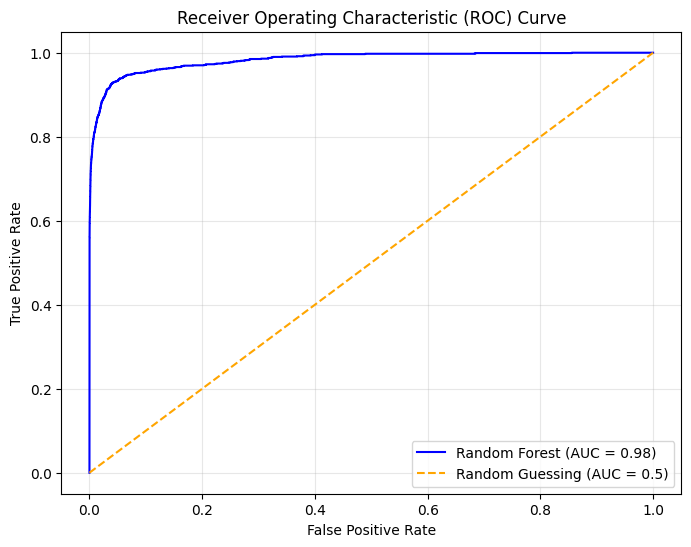

In [ ]:
# Calculate the ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, y_pred_proba_rf)

# Calculate AUC for Random Forest
roc_auc_rf = auc(fpr_rf, tpr_rf)
print(f"AUC-ROC (Random Forest): {roc_auc_rf}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], color='orange', linestyle='--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import pandas as pd

# Combine predicted probabilities and true labels
results = pd.DataFrame({'y_true': y_val, 'y_pred_proba': y_pred_proba_rf})

# Sort by predicted probabilities in descending order
results = results.sort_values(by='y_pred_proba', ascending=False)

In [ ]:
# Select the top 10% of transactions
top_10_percent = results.head(int(0.1 * len(results)))

# Calculate lift
baseline_fraud_rate = y_val.mean()
top_10_fraud_rate = top_10_percent['y_true'].mean()
lift = top_10_fraud_rate / baseline_fraud_rate
print(f"Lift in Top 10%: {lift}")

Lift in Top 10%: 9.525622612504298


This means that the top 10% of the transactions flagged are 9.54 times more likely to be fraudulent compared to a random selection of transactions.

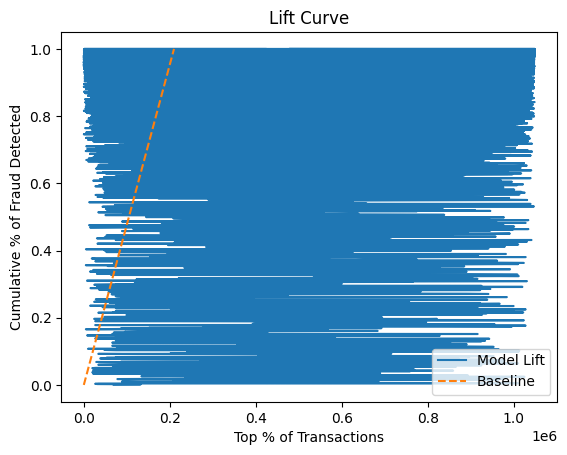

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cumulative actual fraud and baseline fraud
cumulative_actuals = np.cumsum(results['y_true']) / results['y_true'].sum()
baseline = np.linspace(0, 1, len(cumulative_actuals))

# Plot
plt.plot(cumulative_actuals, label='Model Lift')
plt.plot(baseline, linestyle='--', label='Baseline')
plt.xlabel('Top % of Transactions')
plt.ylabel('Cumulative % of Fraud Detected')
plt.title('Lift Curve')
plt.legend()
plt.show()

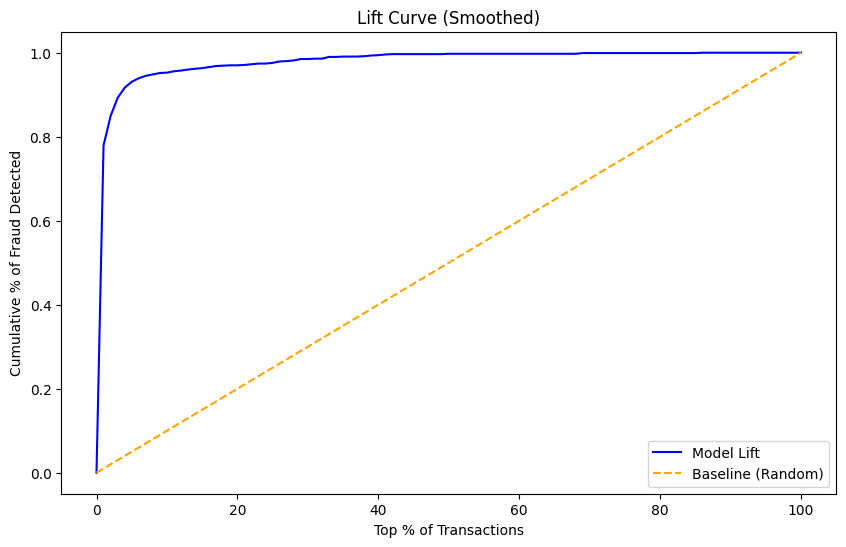

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate cumulative fraud detected (grouped by percentiles)
n_bins = 100  # Number of bins (e.g., 1% increments)
bin_edges = np.linspace(0, len(results), n_bins + 1, dtype=int)
cumulative_actuals = [results['y_true'].iloc[:edge].sum() / results['y_true'].sum() for edge in bin_edges]
baseline = np.linspace(0, 1, len(cumulative_actuals))

# Plot the corrected Lift Curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_actuals, label='Model Lift', color='blue')
plt.plot(baseline, linestyle='--', label='Baseline (Random)', color='orange')
plt.xlabel('Top % of Transactions')
plt.ylabel('Cumulative % of Fraud Detected')
plt.title('Lift Curve (Smoothed)')
plt.legend()
plt.show()


A steep initial slope in the lift curve indicates that the model captures a significant proportion of fraud cases early on

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba_rf)

# Find the threshold with the best trade-off (e.g., high recall with reasonable precision)
best_threshold_index = (precision * recall).argmax()  # Maximize F1 score
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold: {best_threshold:.2f}")

# Apply the new threshold
y_pred_custom = (y_pred_proba_rf >= best_threshold).astype(int)


Best Threshold: 0.82


The threshold of 0.83 refers to the decision boundary used to classify a transaction as fraud or non-fraud based on the model’s predicted probabilities

The threshold determines at what probability you classify a transaction as fraud (class 1):

If the predicted fraud probability is ≥ 0.83, classify the transaction as fraud (class 1).

If the predicted fraud probability is < 0.83, classify it as non-fraud (class 0).

By increasing the threshold to 0.83, model becomes more selective about classifying a transaction as fraud. This prioritizes precision, reducing false positives (legitimate transactions flagged as fraud).

In [ ]:
# Apply the new threshold to get binary predictions
y_pred_custom = (y_pred_proba_rf >= 0.83).astype(int)

from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report with Custom Threshold (0.83):")
print(classification_report(y_val, y_pred_custom, target_names=["Non-Fraud", "Fraud"]))

Classification Report with Custom Threshold (0.83):
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    208514
       Fraud       0.94      0.56      0.70      1201

    accuracy                           1.00    209715
   macro avg       0.97      0.78      0.85    209715
weighted avg       1.00      1.00      1.00    209715



Fraud (Class 1):

Precision: 0.94
94% of transactions flagged as fraud are actual fraud (9% are false positives).
This is quite strong, showing that the model maintains high confidence in its fraud predictions.

Recall: 0.56
The model identifies only 56% of the actual fraud cases, missing 44% (false negatives).
This suggests that the model is conservative at this threshold, preferring to avoid false positives.

lowering threshold

In [ ]:
# Apply a lower threshold
y_pred_custom_lower = (y_pred_proba_rf >= 0.75).astype(int)

# Re-evaluate performance
print(classification_report(y_val, y_pred_custom_lower, target_names=["Non-Fraud", "Fraud"]))

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    208514
       Fraud       0.80      0.63      0.70      1201

    accuracy                           1.00    209715
   macro avg       0.90      0.81      0.85    209715
weighted avg       1.00      1.00      1.00    209715



better balance of precision recall

LIGHT GRADIENT BOOSTING

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report, PrecisionRecallDisplay
import pandas as pd

In [ ]:
# Calculate the scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Scale Pos Weight: {scale_pos_weight}")

Scale Pos Weight: 173.58064516129033


This is quite high - so only use if -
we want the model to prioritize recall for fraud detection (e.g., catching as many fraud cases as possible is critical).

we are okay with tolerating a higher false positive rate (as long as operationally manageable).

precision-recall metrics matter more than accuracy.

In [ ]:
# Initialize the LightGBM model with scale_pos_weight
lgb_model = lgb.LGBMClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=10,  # Limit tree depth to prevent overfitting
    num_leaves=31  # Max leaves in one tree
)

# Train the model
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4805, number of negative: 834055
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2324
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005728 -> initscore=-5.156642
[LightGBM] [Info] Start training from score -5.156642


LGBMClassifier(max_depth=10, random_state=42,
               scale_pos_weight=173.58064516129033)

In [ ]:
# Predict probabilities
y_pred_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

# Predict binary outcomes with default threshold of 0.5
y_pred_lgb = (y_pred_proba_lgb >= 0.5).astype(int)

# Evaluate metrics
roc_auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
print(f"AUC-ROC (LightGBM with scale_pos_weight): {roc_auc_lgb}")

print("Classification Report (LightGBM):")
print(classification_report(y_val, y_pred_lgb))

AUC-ROC (LightGBM with scale_pos_weight): 0.9321454839026377
Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    208514
           1       0.14      0.91      0.25      1201

    accuracy                           0.97    209715
   macro avg       0.57      0.94      0.62    209715
weighted avg       0.99      0.97      0.98    209715



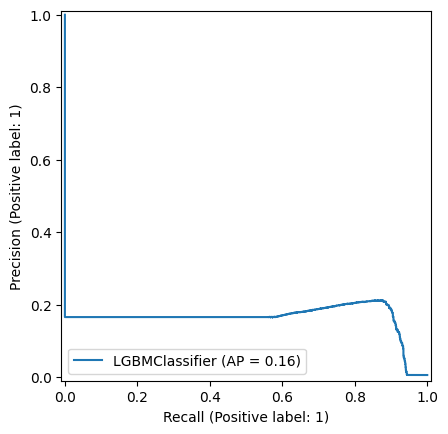

In [ ]:
# Plot Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(lgb_model, X_val, y_val)

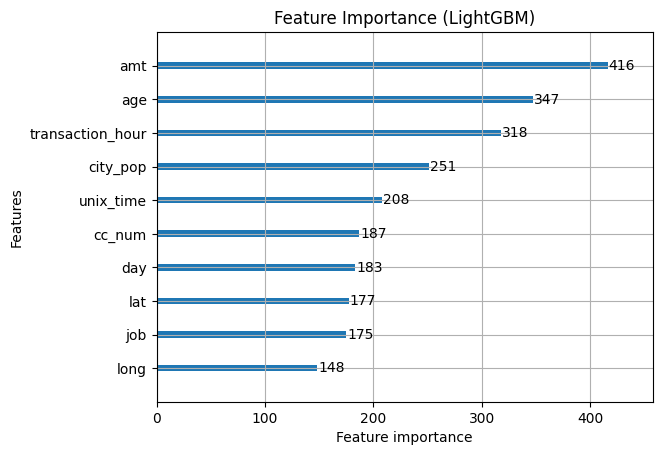

In [ ]:
# Plot feature importance
import matplotlib.pyplot as plt

lgb.plot_importance(lgb_model, max_num_features=10)
plt.title("Feature Importance (LightGBM)")
plt.show()

AUC-ROC (LightGBM): 0.9321454839026377


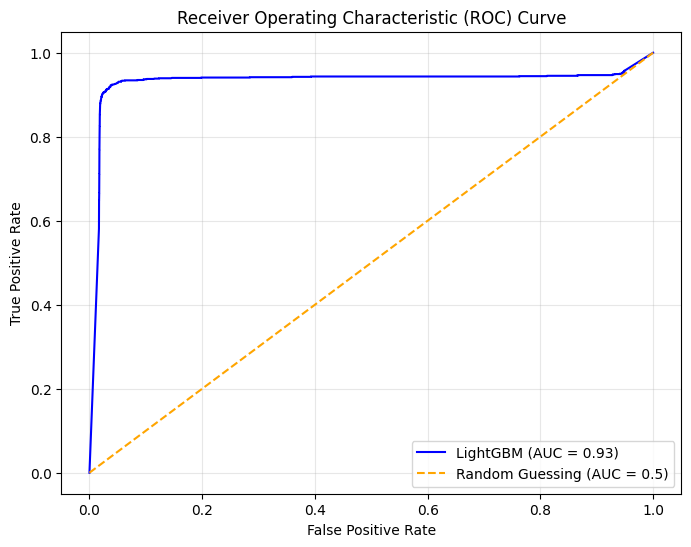

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_lgb)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC (LightGBM): {roc_auc}")

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"LightGBM (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='orange', linestyle='--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Sort predictions by probability in descending order
results = pd.DataFrame({'y_true': y_val, 'y_pred_proba': y_pred_proba_lgb})
results = results.sort_values(by='y_pred_proba', ascending=False)

# Calculate the cumulative fraud rate (lift curve)
cumulative_fraud_detected = np.cumsum(results['y_true']) / results['y_true'].sum()

# Calculate baseline (random guessing)
baseline = np.linspace(0, 1, len(cumulative_fraud_detected))

# Calculate lift at specific percentiles (e.g., Top 10%)
top_10_percent = int(0.1 * len(results))  # Top 10% of transactions
lift_top_10 = cumulative_fraud_detected.iloc[top_10_percent - 1] / baseline[top_10_percent - 1]

print(f"Lift in Top 10%: {lift_top_10:.2f}")

Lift in Top 10%: 9.36


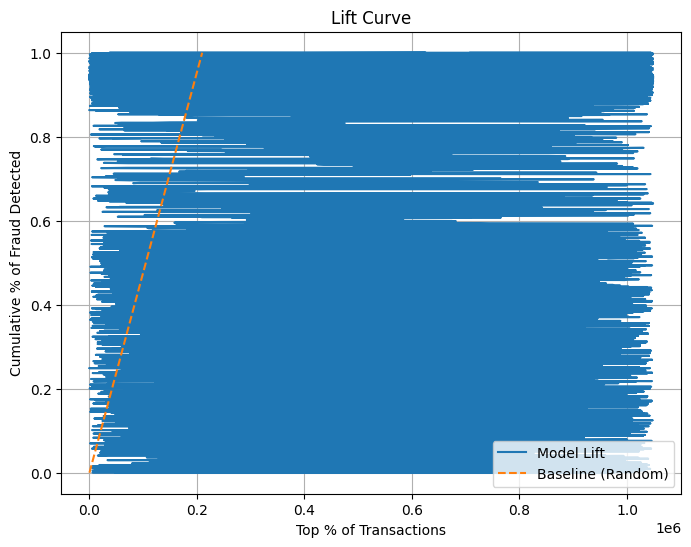

In [ ]:
import matplotlib.pyplot as plt

# Plot the Lift Curve
plt.figure(figsize=(8, 6))
plt.plot(cumulative_fraud_detected, label="Model Lift")
plt.plot(baseline, linestyle='--', label="Baseline (Random)")
plt.xlabel("Top % of Transactions")
plt.ylabel("Cumulative % of Fraud Detected")
plt.title("Lift Curve")
plt.legend()
plt.grid()
plt.show()

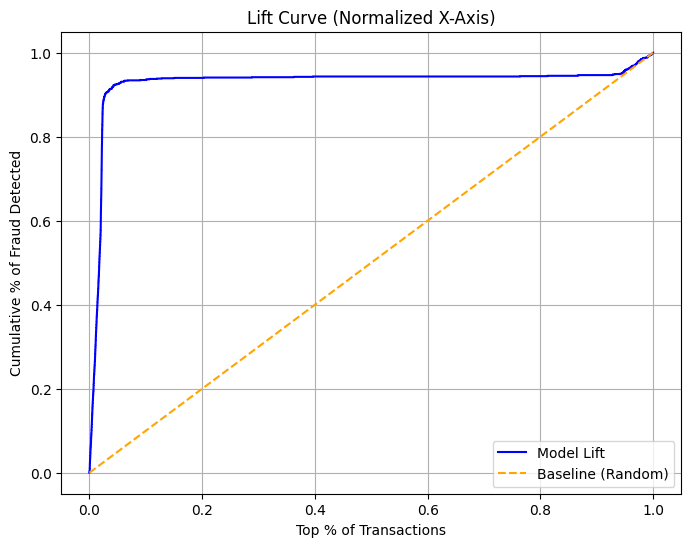

In [ ]:
# Sort by predicted probabilities in descending order
results = results.sort_values(by="y_pred_proba", ascending=False).reset_index(drop=True)

# Calculate cumulative fraud detected
cumulative_fraud_detected = np.cumsum(results["y_true"]) / results["y_true"].sum()

# Normalize x-axis to represent cumulative % of transactions
x_axis_normalized = np.linspace(0, 1, len(results))

# Calculate baseline (random selection)
baseline = np.linspace(0, 1, len(results))

# Plot the normalized Lift Curve
plt.figure(figsize=(8, 6))
plt.plot(x_axis_normalized, cumulative_fraud_detected, label="Model Lift", color="blue")
plt.plot(x_axis_normalized, baseline, linestyle="--", label="Baseline (Random)", color="orange")
plt.xlabel("Top % of Transactions")
plt.ylabel("Cumulative % of Fraud Detected")
plt.title("Lift Curve (Normalized X-Axis)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Calculate Lift at specific top percentiles
top_percentiles = [0.01, 0.05, 0.1]  # Top 1%, 5%, 10%
for percentile in top_percentiles:
    top_n = int(percentile * len(results))
    lift = cumulative_fraud_detected[top_n - 1] / baseline[top_n - 1]
    print(f"Lift in Top {int(percentile * 100)}%: {lift:.2f}")

Lift in Top 1%: 27.83
Lift in Top 5%: 18.52
Lift in Top 10%: 9.36


The very high lift values in the top 1% and 5% show that the model is excellent at detecting fraud cases in the most high-risk transactions.

In [ ]:
thresholds = [0.5, 0.75, 0.9]
for threshold in thresholds:
    y_pred_custom = (y_pred_proba_lgb >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_val, y_pred_custom, target_names=["Non-Fraud", "Fraud"]))

Threshold: 0.5
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.98    208514
       Fraud       0.14      0.91      0.25      1201

    accuracy                           0.97    209715
   macro avg       0.57      0.94      0.62    209715
weighted avg       0.99      0.97      0.98    209715

Threshold: 0.75
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99    208514
       Fraud       0.18      0.90      0.30      1201

    accuracy                           0.98    209715
   macro avg       0.59      0.94      0.64    209715
weighted avg       0.99      0.98      0.98    209715

Threshold: 0.9
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.98      0.99    208514
       Fraud       0.20      0.89      0.33      1201

    accuracy                           0.98    209715
   macro avg       0.60      0.93      0.66    209715
weighted avg       0.99     